In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Research-style plotting theme
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2
)

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
import pingouin as pg

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


[*********************100%***********************]  3 of 3 completed


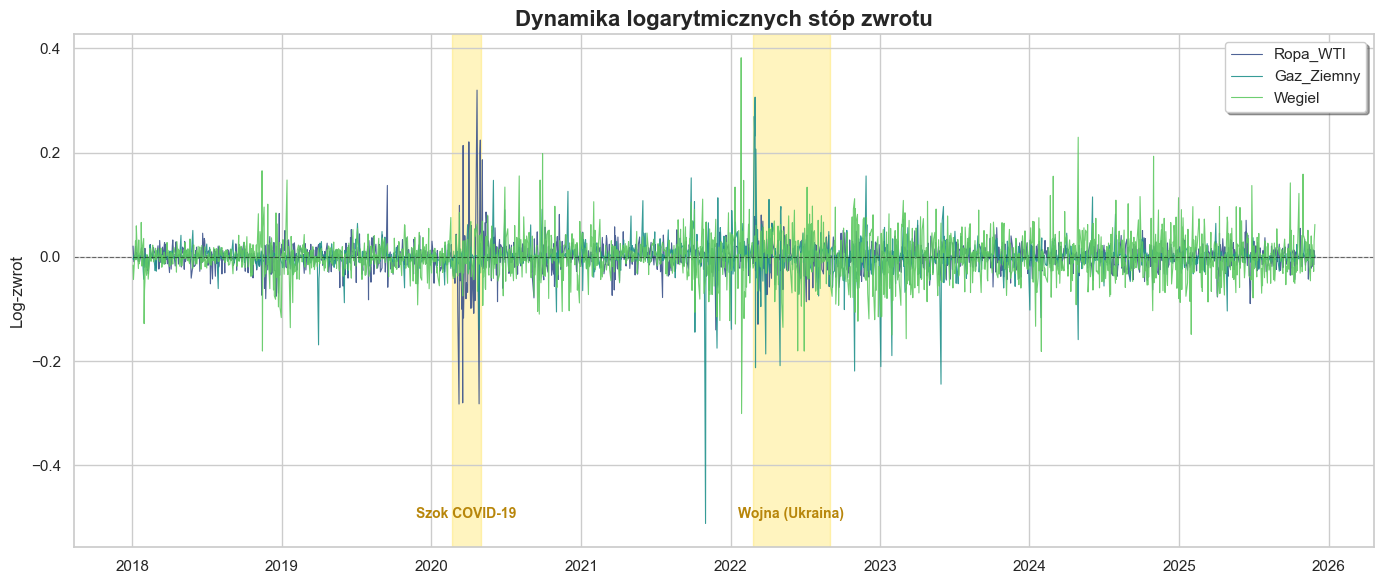

In [ ]:
tickers = ['CL=F', 'NG=F', 'MTF=F']
names   = ['Ropa_WTI', 'Gaz_Ziemny', 'Wegiel']

dane = yf.download(
    tickers,
    start='2018-01-01',
    end='2025-12-01',
    auto_adjust=False,
    threads=False,
    timeout=20
)['Adj Close']

dane = dane.ffill().dropna()

# Logarytmiczne stopy zwrotu
log_returns = np.log(dane / dane.shift(1)).dropna()
log_returns.columns = names
log_returns.index = pd.to_datetime(log_returns.index)

# KONFIGURACJA STYLU
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=len(log_returns.columns))

# TWORZENIE WYKRESU
fig, ax = plt.subplots(figsize=(14, 6))

# --- RYSOWANIE DANYCH Z LOG_RETURNS ---
# Iterujemy po kolumnach Twojego DataFrame
for i, col in enumerate(log_returns.columns):
    sns.lineplot(
        x=log_returns.index,
        y=log_returns[col],
        ax=ax,
        label=col,
        color=palette[i],
        linewidth=0.8, # Cieńsza linia dla lepszej czytelności przy dużym zagęszczeniu danych
        alpha=0.9
    )

# --- DODAWANIE WYRÓŻNIEŃ (COVID + WOJNA) ---
events = [
    {
        'start': pd.Timestamp('2020-02-20'),
        'end': pd.Timestamp('2020-05-01'),
        'label': 'Szok COVID-19',
        'color': '#ffd700' # Żółty
    },
    {
        'start': pd.Timestamp('2022-02-24'),
        # Koniec zaznaczenia ustawiony na sierpień, by objąć szczyt kryzysu energetycznego
        'end': pd.Timestamp('2022-08-31'),
        'label': 'Wojna (Ukraina)',
        'color': '#ffd700'
    }
]

for event in events:
    # Rysujemy tylko jeśli zdarzenie mieści się w zakresie danych
    if event['start'] < log_returns.index.max() and event['end'] > log_returns.index.min():
        # Żółty pasek w tle
        ax.axvspan(event['start'], event['end'], color=event['color'], alpha=0.25, zorder=0)

        # Etykieta tekstowa
        mid_point = event['start'] + (event['end'] - event['start']) / 2
        y_min, y_max = ax.get_ylim()

        ax.text(
            mid_point,
            y_min + 0.05 * (y_max - y_min),  # 5% wysokości od dołu
            event['label'],
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=10,
            fontweight='bold',
            color='darkgoldenrod'
        )


# --- FORMATOWANIE FINALNE ---
ax.set_title('Dynamika logarytmicznych stóp zwrotu', fontsize=16, fontweight='bold')
ax.set_ylabel('Log-zwrot')
ax.set_xlabel('')
ax.legend(loc='upper right', frameon=True, shadow=True)

# Linia pozioma na 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Formatowanie osi czasu (lata)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()



ANALIZA EKSPLORACYJNA (EDA)

Statystyki opisowe log-zwrotów:
                mean       std       min       max      skew   kurtosis
Ropa_WTI    0.000287  0.029532 -0.282206  0.319634  0.034546  26.398513
Gaz_Ziemny  0.000002  0.029886 -0.511258  0.306201 -2.565599  66.549783
Wegiel      0.000213  0.042961 -0.300480  0.381727  0.241556   6.183989


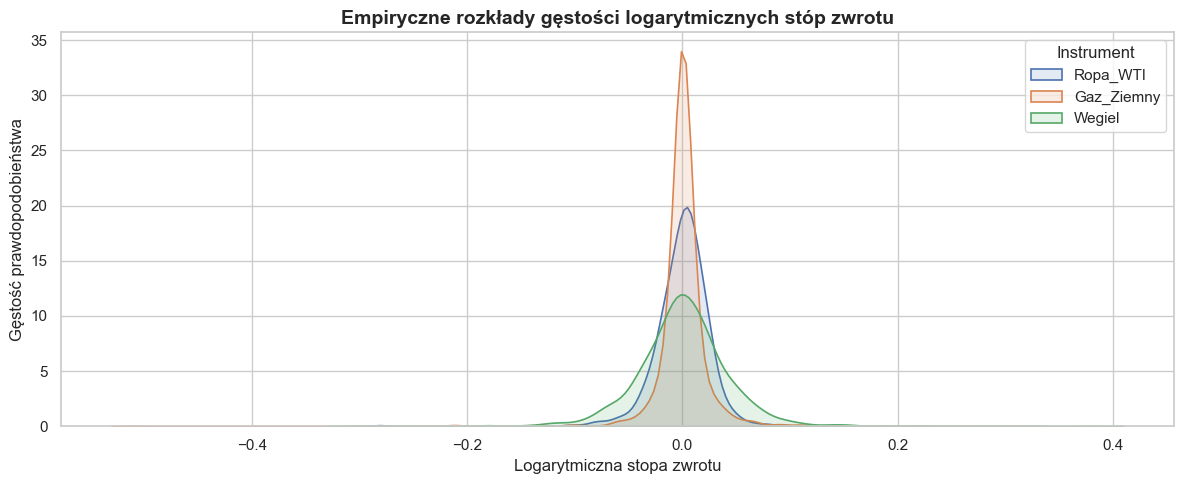

In [ ]:
print("\nANALIZA EKSPLORACYJNA (EDA)")

# Statystyki opisowe
desc_stats = log_returns.describe().T
desc_stats['skew'] = log_returns.skew()
desc_stats['kurtosis'] = log_returns.kurtosis()
print("\nStatystyki opisowe log-zwrotów:")
print(desc_stats[['mean', 'std', 'min', 'max', 'skew', 'kurtosis']])

# Wykresy gęstości (Density Plots)
plt.figure(figsize=(12, 5))

for i, col in enumerate(log_returns.columns):
    sns.kdeplot(
        data=log_returns[col],
        label=col,
        fill=True,
        alpha=0.15,
        linewidth=1.2
    )

plt.title(
    'Empiryczne rozkłady gęstości logarytmicznych stóp zwrotu',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Logarytmiczna stopa zwrotu', fontsize=12)
plt.ylabel('Gęstość prawdopodobieństwa', fontsize=12)
plt.legend(title='Instrument', frameon=True)
plt.tight_layout()
plt.show()

In [ ]:
def check_stationarity(df):
    results = {}
    for col in df.columns:
        res = adfuller(df[col], autolag='AIC')
        results[col] = {
            'Test Statistic': round(res[0], 4),
            'p-value': res[1]
        }
    return pd.DataFrame(results).T

# 1. Test dla poziomów (Ceny)
print("Test ADF dla poziomów (ceny):")
print(check_stationarity(log_returns))

Test ADF dla poziomów (ceny):
            Test Statistic       p-value
Ropa_WTI           -7.7564  9.709830e-12
Gaz_Ziemny        -20.7677  0.000000e+00
Wegiel            -20.8559  0.000000e+00


In [ ]:
def diagnostyka_var_stability(var_result):
    """Sprawdza stabilność modelu VAR."""
    is_stable = var_result.is_stable()
    print(f"\n--- Diagnostyka VAR: Stabilność ---")
    print(f"Czy model VAR jest stabilny? {'TAK' if is_stable else 'NIE'}")
    return is_stable

def diagnostyka_var_whiteness(var_result, lags=10):
    """Test Portmanteau na autokorelację reszt wielowymiarowych."""
    print(f"\n--- Diagnostyka VAR: Test Portmanteau (Whiteness) ---")
    whiteness = var_result.test_whiteness(nlags=lags, signif=0.05, adjusted=True)
    print(whiteness.summary())

def dopasuj_var(data):
    """Dopasowuje model VAR i zwraca obiekt wyników oraz reszty."""
    model = VAR(data)
    lag_order_results = model.select_order(maxlags=10)
    print("\n--- Wybór rzędu opóźnień VAR ---")
    print(lag_order_results.summary())
    best_lag = lag_order_results.hqic

    var_result = model.fit(best_lag)
    residuals = var_result.resid
    return var_result, residuals, model

var_result, var_residuals, var_model = dopasuj_var(log_returns)
diagnostyka_var_stability(var_result)
diagnostyka_var_whiteness(var_result)



--- Wybór rzędu opóźnień VAR ---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.37     -20.37*   1.417e-09      -20.37
1       -20.38      -20.35   1.404e-09     -20.37*
2       -20.39      -20.33   1.402e-09      -20.36
3      -20.39*      -20.31  1.396e-09*      -20.36
4       -20.39      -20.28   1.397e-09      -20.35
5       -20.39      -20.25   1.401e-09      -20.34
6       -20.38      -20.22   1.407e-09      -20.32
7       -20.39      -20.20   1.402e-09      -20.32
8       -20.38      -20.17   1.408e-09      -20.30
9       -20.38      -20.14   1.409e-09      -20.29
10      -20.37      -20.11   1.418e-09      -20.28
--------------------------------------------------

Wybrany rząd opóźnień VAR (AIC): 1

--- Diagnostyka VAR: Stabilność ---
Czy model VAR jest stabilny? TAK

--- Diagnostyka VAR: Test Portmanteau (Whiteness) ---
Adjusted Portmanteau-test for residual a

c:\Users\W11Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
def diagnostyka_arch_effects(residuals, lags=10):
    print(f"\n--- Diagnostyka VAR: Testy efektów ARCH (Heteroskedastyczność) ---")
    arch_results = []

    for col in residuals.columns:
        # het_arch zwraca: (LM-stat, p-value, f-stat, f-p-value)
        res = het_arch(residuals[col], nlags=lags)
        arch_results.append({
            'Instrument': col,
            'ARCH-LM Stat': round(res[0], 4),
            'p-value': round(res[1], 10),
            'ARCH Effect': 'TAK' if res[1] < 0.05 else 'NIE'
        })

    df_arch = pd.DataFrame(arch_results)
    print(df_arch.to_string(index=False))
    return df_arch

arch_test_results = diagnostyka_arch_effects(var_residuals)


--- Diagnostyka VAR: Testy efektów ARCH (Heteroskedastyczność) ---
Instrument  ARCH-LM Stat      p-value ARCH Effect
  Ropa_WTI      446.6172 0.000000e+00         TAK
Gaz_Ziemny       69.0142 1.000000e-10         TAK
    Wegiel      154.8133 0.000000e+00         TAK


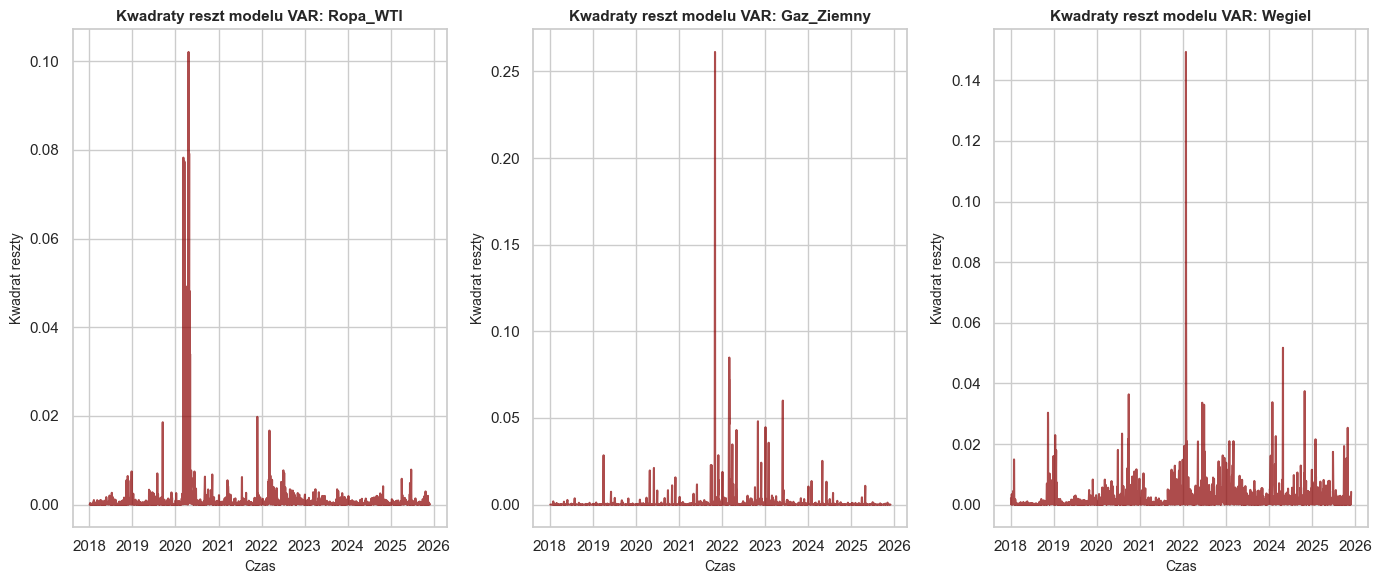

In [ ]:
def plot_residual_squares(residuals):
    """Wizualizacja kwadratów reszt modelu VAR – identyfikacja grupowania zmienności."""

    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    # Kwadraty reszt
    res_sq = residuals ** 2

    for i, col in enumerate(res_sq.columns):
        plt.subplot(1, 3, i + 1)
        sns.lineplot(data=res_sq[col], color='darkred', alpha=0.7)

        plt.title(
            f'Kwadraty reszt modelu VAR: {col}',
            fontsize=11,
            fontweight='bold'
        )
        plt.xlabel('Czas', fontsize=10)
        plt.ylabel('Kwadrat reszty', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_residual_squares(var_residuals)


In [ ]:
from scipy import stats

def fit_dcc_r(residuals, models_list, dists_list, mv_dist):
    """
    Estymacja modelu DCC-GARCH(1,1) w R (rmgarch) oraz diagnostyka reszt.
    models_list  – lista modeli GARCH ['GARCH','EGARCH','GJR-GARCH']
    dists_list   – lista rozkładów jednowymiarowych ['normal','t']
    mv_dist      – rozkład wielowymiarowy DCC: 'normal' lub 't'
    """
    with localconverter(ro.default_converter + pandas2ri.converter):
        try:
            rugarch = importr("rugarch")
            rmgarch = importr("rmgarch")
        except:
            return None, None, False, None

        r_data = ro.conversion.py2rpy(residuals)
        specs = []

        # --- SPECYFIKACJE JEDNOWYMIAROWE ---
        for i in range(len(models_list)):
            m = models_list[i]
            d = dists_list[i]

            r_m = 'sGARCH' if m=='GARCH' else ('eGARCH' if m=='EGARCH' else 'gjrGARCH')
            r_d = 'std' if d=='t' else 'norm'

            spec = rugarch.ugarchspec(
                variance_model=ro.ListVector({"model": r_m,"garchOrder": ro.IntVector([1,1])}),
                mean_model=ro.ListVector({"armaOrder": ro.IntVector([0,0]),"include.mean": False}),
                distribution_model=r_d
            )
            specs.append(spec)

        multispec = rugarch.multispec(ro.ListVector(specs))
        r_mv_dist = 'mvt' if mv_dist=='t' else 'mvnorm'

        dcc_spec = rmgarch.dccspec(uspec=multispec, dccOrder=ro.IntVector([1,1]), distribution=r_mv_dist)

        try:
            fit = rmgarch.dccfit(dcc_spec, data=r_data, solver="solnp")

            # Korelacje warunkowe
            r_corrs = ro.r['rcor'](fit)
            corrs = np.array(r_corrs)
            corrs = np.transpose(corrs, (2,0,1))

            # Zestandaryzowane reszty
            r_resid = ro.r['residuals'](fit)
            r_sigma = ro.r['sigma'](fit)
            std_resid = np.array(r_resid)/np.array(r_sigma)

            # --- DIAGNOSTYKA ROZKŁADU WARUNKOWEGO ---
            distribution_tests = {}
            for i, col in enumerate(residuals.columns):
                s = std_resid[i,:]  # reszty zestandaryzowane dla danego szeregu
                if dists_list[i] == 'normal':
                    stat, pval = stats.shapiro(s)
                    distribution_tests[col] = {"Test":"Shapiro-Wilk","p-value":pval}
                else:
                    # test Kolmogorova-Smirnova dla rozkładu t-Studenta
                    df_fit = stats.t.fit(s)
                    stat, pval = stats.kstest(s, 't', args=df_fit)
                    distribution_tests[col] = {"Test":"KS t-Studenta","p-value":pval}

            return corrs, std_resid, True, distribution_tests

        except Exception:
            return None, None, False, None


In [ ]:
# 4. PRZYPADEK SPECJALNY (OPTYMALIZACJA)
print("\n>>> 4. Przypadek Specjalny: Dobór modeli brzegowych...")
results = {}
best_cfgs = []
best_std_resid_df = pd.DataFrame(index=var_residuals.index)
distribution_tests_results = []

for col in var_residuals.columns:
    best_aic = np.inf
    best_pair = None
    best_res = None

    for m in ['GARCH', 'EGARCH', 'GJR-GARCH']:
        for d in ['normal', 't']:
            try:
                am = arch_model(
                    var_residuals[col],
                    vol='GARCH' if m != 'EGARCH' else 'EGARCH',
                    p=1, o=1 if m=='GJR-GARCH' else 0, q=1,
                    dist=d
                )
                res = am.fit(disp='off')
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_pair = (m, d)
                    best_res = res
            except:
                continue

    best_cfgs.append(best_pair)
    if best_res:
        std_resid = best_res.resid / best_res.conditional_volatility
        best_std_resid_df[col] = std_resid

        # --- Test zgodności rozkładu warunkowego ---
        if best_pair[1] == 'normal':
            stat, pval = stats.shapiro(std_resid)
            test_name = "Shapiro-Wilk"
        else:
            df_fit = stats.t.fit(std_resid)
            stat, pval = stats.kstest(std_resid, 't', args=df_fit)
            test_name = "Kolmogorov-Smirnov t-Studenta"

        distribution_tests_results.append({
            "Instrument": col,
            "Najlepszy Model": f"{best_pair[0]} + {best_pair[1]}",
            "Test Zgodności": test_name,
            "Statystyka": stat,
            "p-value": pval,
            "Zgodny z rozkładem?": "TAK" if pval > 0.05 else "NIE"
        })

    print(f"  {col}: Najlepszy -> {best_pair[0]} + {best_pair[1]}")

# Konwersja wyników testów do DataFrame
df_distribution_tests = pd.DataFrame(distribution_tests_results)
print("\n>>> Wyniki testów zgodności rozkładu warunkowego dla reszt zestandaryzowanych:")
print(df_distribution_tests.to_string(index=False))

# Test wielowymiarowej normalności
clean_resid = best_std_resid_df.dropna()
hz_test = pg.multivariate_normality(clean_resid)
print(f"\nTest Henze-Zirklera (MV Norm): HZ={hz_test.hz:.4f}, p-val={hz_test.pval:.6f}, Normalny? {hz_test.normal}")

special_mv_dist = 'normal' if hz_test.normal else 't'
print(f"=> Decyzja dla modelu DCC: Wielowymiarowy rozkład {special_mv_dist.upper()}")

# A. Przypadek Specjalny (Optymalny)
opt_m = [x[0] for x in best_cfgs]
opt_d = [x[1] for x in best_cfgs]
scenarios = {}
scenarios[f"SPECIAL (Best Univar + DCC-{special_mv_dist})"] = (opt_m, opt_d, special_mv_dist)

print(f"\n>>> Estymacja finalnego modelu: {opt_m} | Rozkłady: {opt_d} | DCC: {special_mv_dist}")
# --- 5. ESTYMACJA I WYNIKI FINALNEGO (OPTYMALNEGO) MODELU ---

print(f"\n>>> ROZPOCZYNAM OBLICZENIA DLA MODELU SPECJALNEGO:")
print(f"    Modele brzegowe: {opt_m}")
print(f"    Rozkłady brzegowe: {opt_d}")
print(f"    Rozkład wielowymiarowy (DCC): {special_mv_dist.upper()}")

# 1. Uruchomienie estymacji w R (za pomocą Twojej funkcji fit_dcc_r)
# Używamy zmiennych var_residuals (dane), opt_m (lista modeli), opt_d (lista rozkładów), special_mv_dist (rozkład DCC)
opt_corrs, opt_std_resid, status, dist_tests = fit_dcc_r(var_residuals, opt_m, opt_d, special_mv_dist)
if status:
    # 2. Obliczenie średnich korelacji z wyniku (opt_corrs ma wymiary [T, 3, 3])
    # Indeksy: 0=Ropa, 1=Gaz, 2=Węgiel
    mean_corr_rope_gas = np.mean(opt_corrs[:, 0, 1])
    mean_corr_rope_coal = np.mean(opt_corrs[:, 0, 2])
    mean_corr_gas_coal = np.mean(opt_corrs[:, 1, 2])

    # 3. Przygotowanie tabeli wyników
    summary_opt_data = [[
        f"SPECIAL ({'/'.join(opt_m)} | DCC-{special_mv_dist})",
        mean_corr_rope_gas,
        mean_corr_rope_coal,
        mean_corr_gas_coal
    ]]

    df_opt_summary = pd.DataFrame(
        summary_opt_data,
        columns=["Model", "Ropa WTI – Gaz Ziemny", "Ropa WTI – Węgiel", "Gaz Ziemny – Węgiel"]
    )

    print("\n>>> Średnie warunkowe korelacje dla modelu optymalnego:")
    print(df_opt_summary.round(4).to_string(index=False))

    # 4. (Opcjonalnie) Jeśli chcesz zapisać ten wynik do słownika results do późniejszego wykresu
    results[f"SPECIAL (Best Univar + DCC-{special_mv_dist})"] = opt_corrs

else:
    print("\n>>> BŁĄD KRYTYCZNY: Estymacja modelu optymalnego w R zakończyła się niepowodzeniem.")
    print("    Sprawdź czy pakiet rmgarch/rugarch nie zwrócił błędu zbieżności (convergence error).")


>>> 4. Przypadek Specjalny: Dobór modeli brzegowych...
  Ropa_WTI: Najlepszy -> EGARCH + t


C:\Users\W11Home\AppData\Local\Temp\ipykernel_27180\542142689.py:22: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


  Gaz_Ziemny: Najlepszy -> GARCH + t
  Wegiel: Najlepszy -> EGARCH + t

>>> Wyniki testów zgodności rozkładu warunkowego dla reszt zestandaryzowanych:
Instrument Najlepszy Model                Test Zgodności  Statystyka  p-value Zgodny z rozkładem?
  Ropa_WTI      EGARCH + t Kolmogorov-Smirnov t-Studenta    0.022999 0.240029                 TAK
Gaz_Ziemny       GARCH + t Kolmogorov-Smirnov t-Studenta    0.020718 0.355934                 TAK
    Wegiel      EGARCH + t Kolmogorov-Smirnov t-Studenta    0.015352 0.730771                 TAK

Test Henze-Zirklera (MV Norm): HZ=34.5709, p-val=0.000000, Normalny? False
=> Decyzja dla modelu DCC: Wielowymiarowy rozkład T

>>> Estymacja finalnego modelu: ['EGARCH', 'GARCH', 'EGARCH'] | Rozkłady: ['t', 't', 't'] | DCC: t

>>> ROZPOCZYNAM OBLICZENIA DLA MODELU SPECJALNEGO:
    Modele brzegowe: ['EGARCH', 'GARCH', 'EGARCH']
    Rozkłady brzegowe: ['t', 't', 't']
    Rozkład wielowymiarowy (DCC): T

>>> Średnie warunkowe korelacje dla modelu optymal

In [ ]:
# B. Przypadki Jednorodne (Siatka 3 modele x 2 rozkłady)
models = ['GARCH', 'EGARCH', 'GJR-GARCH']
dists  = ['normal', 't']
mv_dists = ['normal', 't']

for m in models:
    for d in dists:
        for mv in mv_dists:
            name = f"{m} + {d} | DCC-{mv}"
            scenarios[name] = ([m]*3, [d]*3, mv)

print(f"\n>>> Rozpoczynam estymację {len(scenarios)} scenariuszy DCC...")
results = {}
distribution_results = {}

for name, (ms, ds, mv) in scenarios.items():
    print(f"  Estymacja: {name}...", end=" ")
    corrs, std_resid, status, dist_tests = fit_dcc_r(var_residuals, ms, ds, mv)
    if status:
        results[name] = corrs
        distribution_results[name] = dist_tests
        print("OK")
    else:
        print("FAIL (Brak zbieżności)")

# 7. TABELA PODSUMOWUJĄCA ŚREDNIE KORELACJE
print("\n>>> Podsumowanie średnich korelacji dla wszystkich modeli:")
summary_data = []
pairs_idx = [(0,1), (0,2), (1,2)]
pair_names = [f"{log_returns.columns[p[0]]}-{log_returns.columns[p[1]]}" for p in pairs_idx]

for name, corr in results.items():
    row = [name]
    for (i, j) in pairs_idx:
        row.append(np.mean(corr[:, i, j]))
    summary_data.append(row)

sum_df = pd.DataFrame(summary_data, columns=["Model"] + pair_names)
print(sum_df.round(4).to_string(index=False))

# 8. NOWA TABELA PODSUMOWUJĄCA P-WARTOŚCI TESTÓW ROZKŁADU
print("\n>>> Podsumowanie p-wartości testów rozkładu dla wszystkich modeli:")
pval_data = []

for name, tests in distribution_results.items():
    row = [name]
    for col in var_residuals.columns:
        row.append(tests[col]['p-value'])
    pval_data.append(row)

pval_df = pd.DataFrame(pval_data, columns=["Model"] + list(var_residuals.columns))
print(pval_df.round(4).to_string(index=False))



>>> Rozpoczynam estymację 13 scenariuszy DCC...
  Estymacja: SPECIAL (Best Univar + DCC-t)... OK
  Estymacja: GARCH + normal | DCC-normal... OK
  Estymacja: GARCH + normal | DCC-t... OK
  Estymacja: GARCH + t | DCC-normal... OK
  Estymacja: GARCH + t | DCC-t... OK
  Estymacja: EGARCH + normal | DCC-normal... OK
  Estymacja: EGARCH + normal | DCC-t... OK
  Estymacja: EGARCH + t | DCC-normal... OK
  Estymacja: EGARCH + t | DCC-t... OK
  Estymacja: GJR-GARCH + normal | DCC-normal... OK
  Estymacja: GJR-GARCH + normal | DCC-t... OK
  Estymacja: GJR-GARCH + t | DCC-normal... OK
  Estymacja: GJR-GARCH + t | DCC-t... OK

>>> Podsumowanie średnich korelacji dla wszystkich modeli:
                          Model  Ropa_WTI-Gaz_Ziemny  Ropa_WTI-Wegiel  Gaz_Ziemny-Wegiel
  SPECIAL (Best Univar + DCC-t)               0.0905           0.0884             0.0221
    GARCH + normal | DCC-normal               0.1052           0.0873             0.0228
         GARCH + normal | DCC-t               0.105

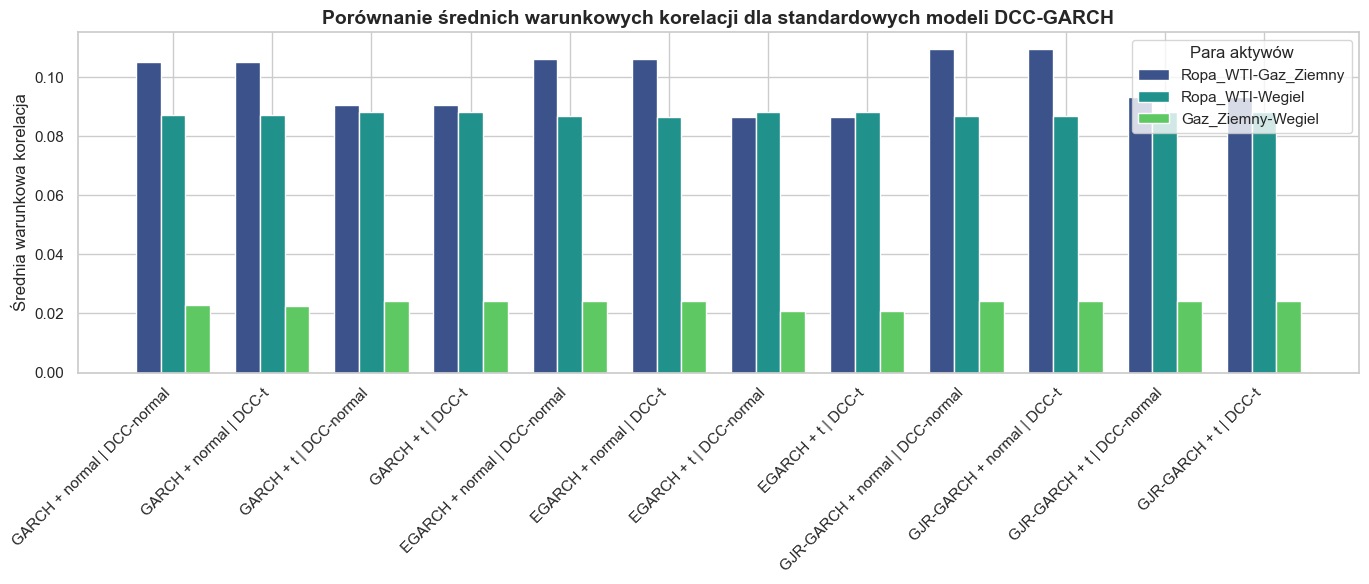

In [ ]:

df_plot = sum_df[sum_df['Model'] != 'SPECIAL (Best Univar + DCC-t)'].copy()

for col in df_plot.columns[1:]:
    df_plot[col] = df_plot[col].astype(float)

pairs = df_plot.columns[1:]
x = np.arange(len(df_plot))  # pozycje dla modeli
width = 0.25  # szerokość słupków

# Paleta viridis
colors = sns.color_palette("viridis", n_colors=len(pairs))

fig, ax = plt.subplots(figsize=(14,6))

for i, pair in enumerate(pairs):
    ax.bar(x + i*width, df_plot[pair], width, label=pair, color=colors[i])

ax.set_xticks(x + width)
ax.set_xticklabels(df_plot['Model'], rotation=45, ha='right')
ax.set_ylabel("Średnia warunkowa korelacja")
ax.set_title("Porównanie średnich warunkowych korelacji dla standardowych modeli DCC-GARCH", fontsize=14, fontweight='bold')
ax.legend(title="Para aktywów")
plt.tight_layout()
plt.show()

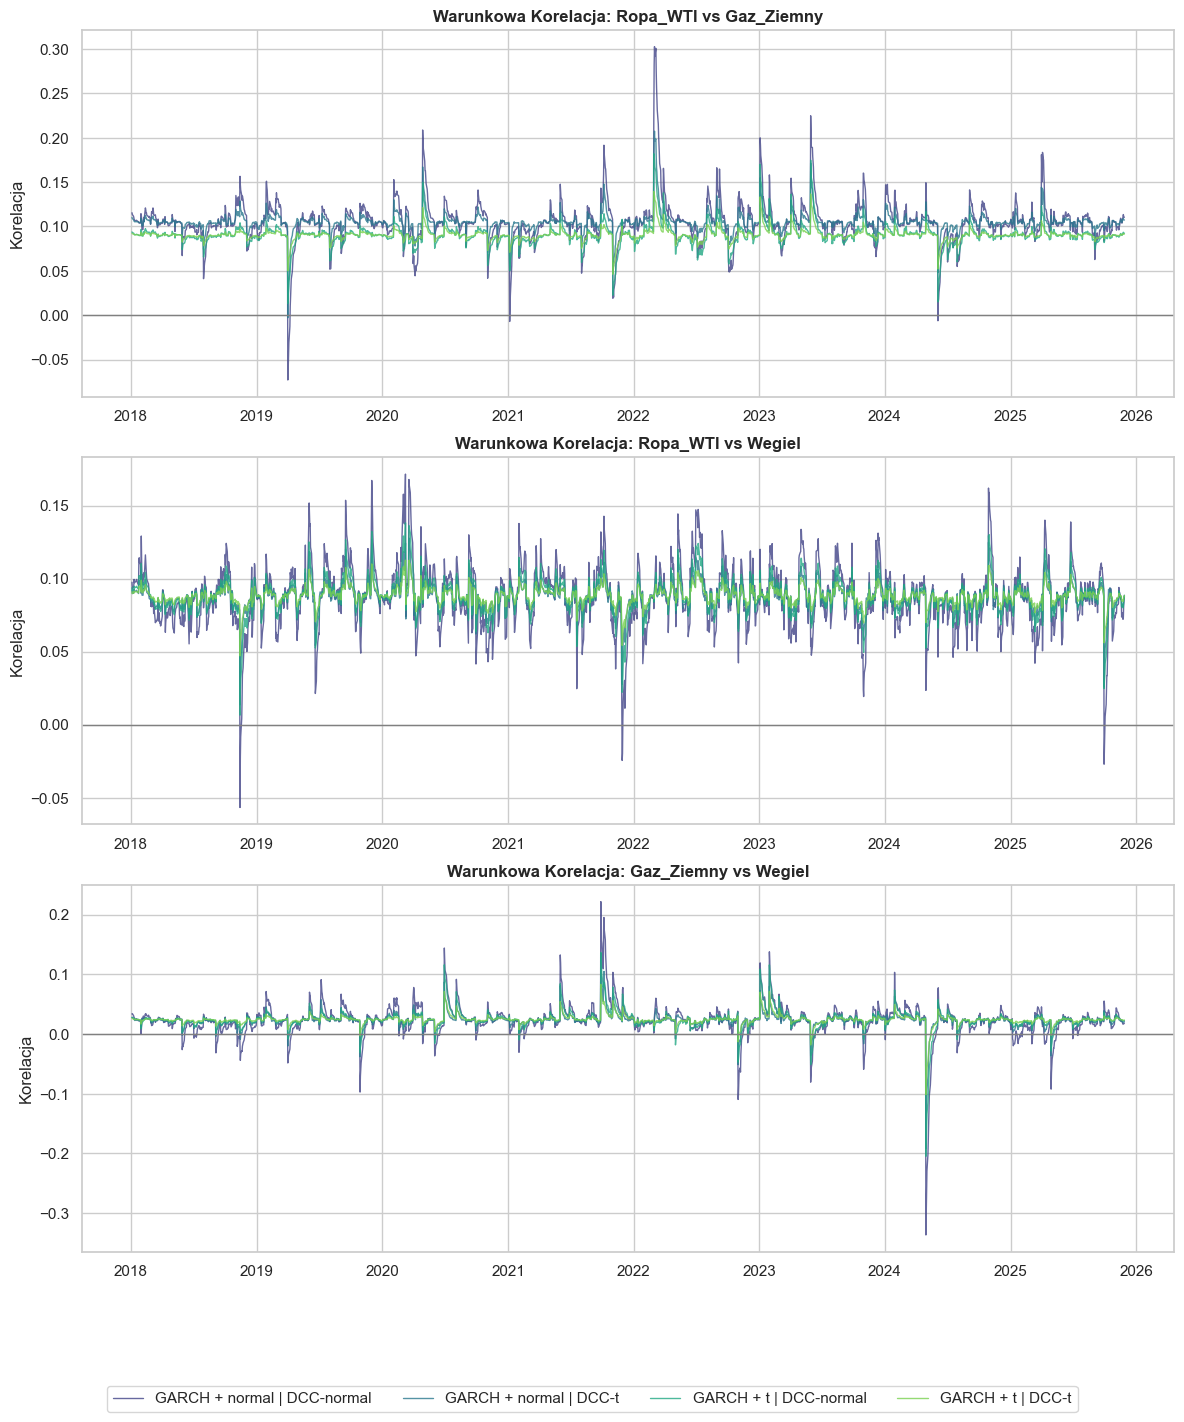

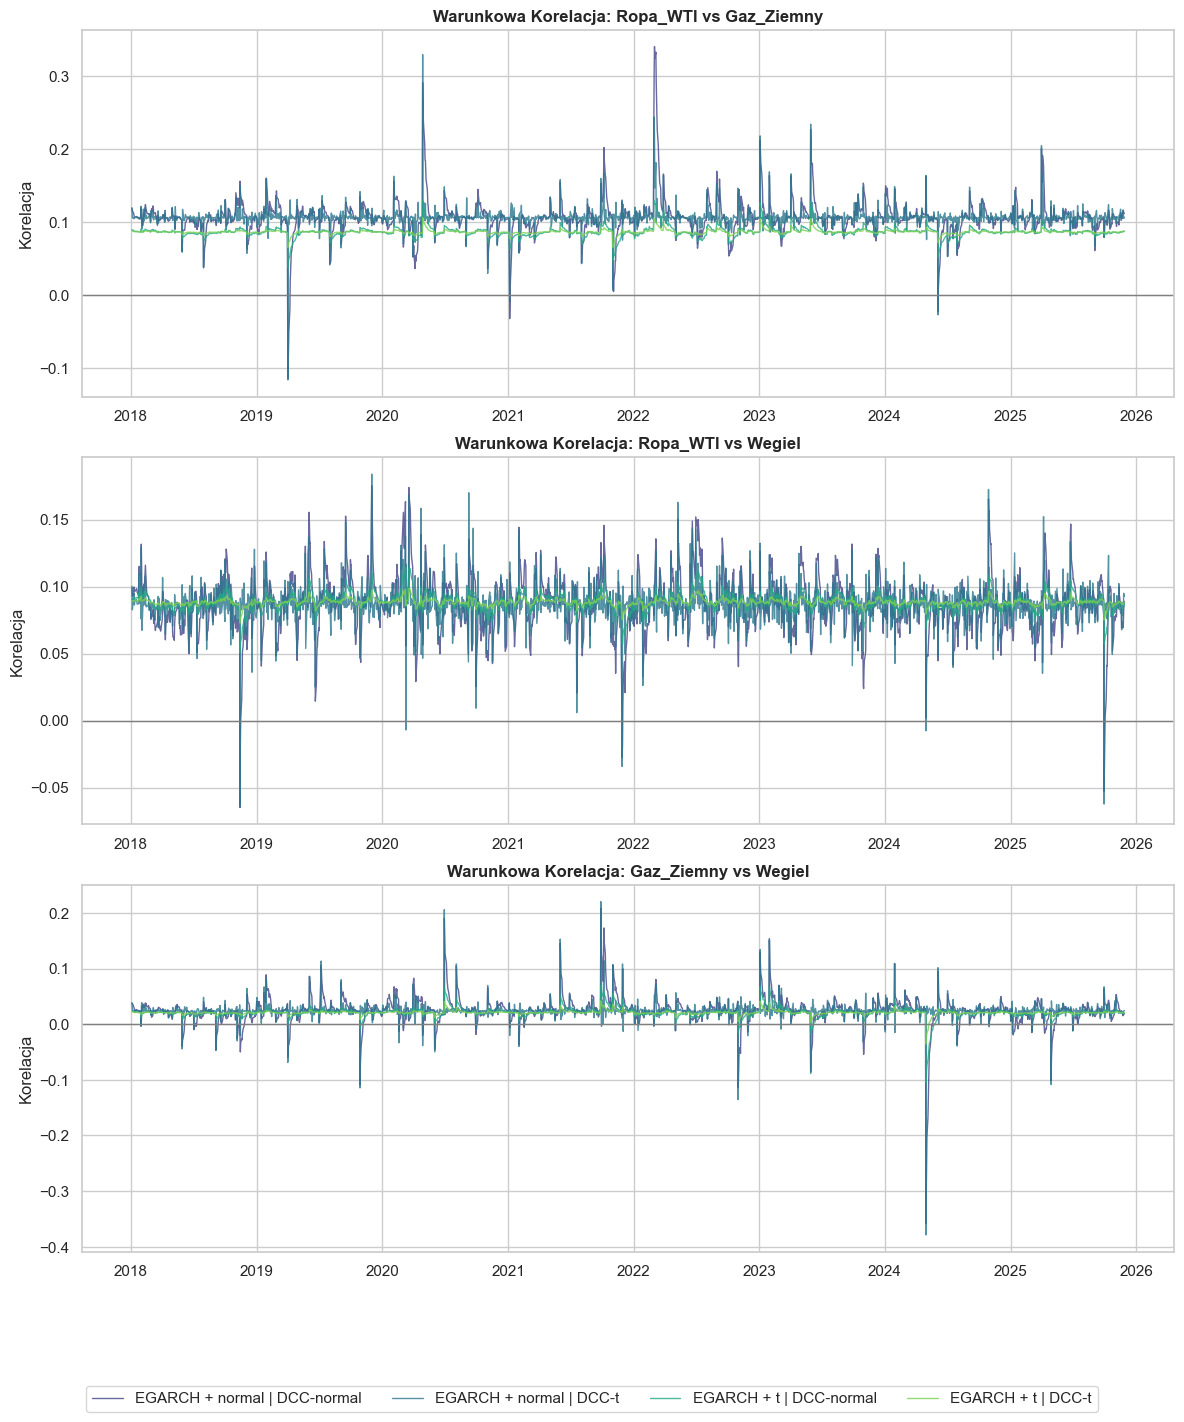

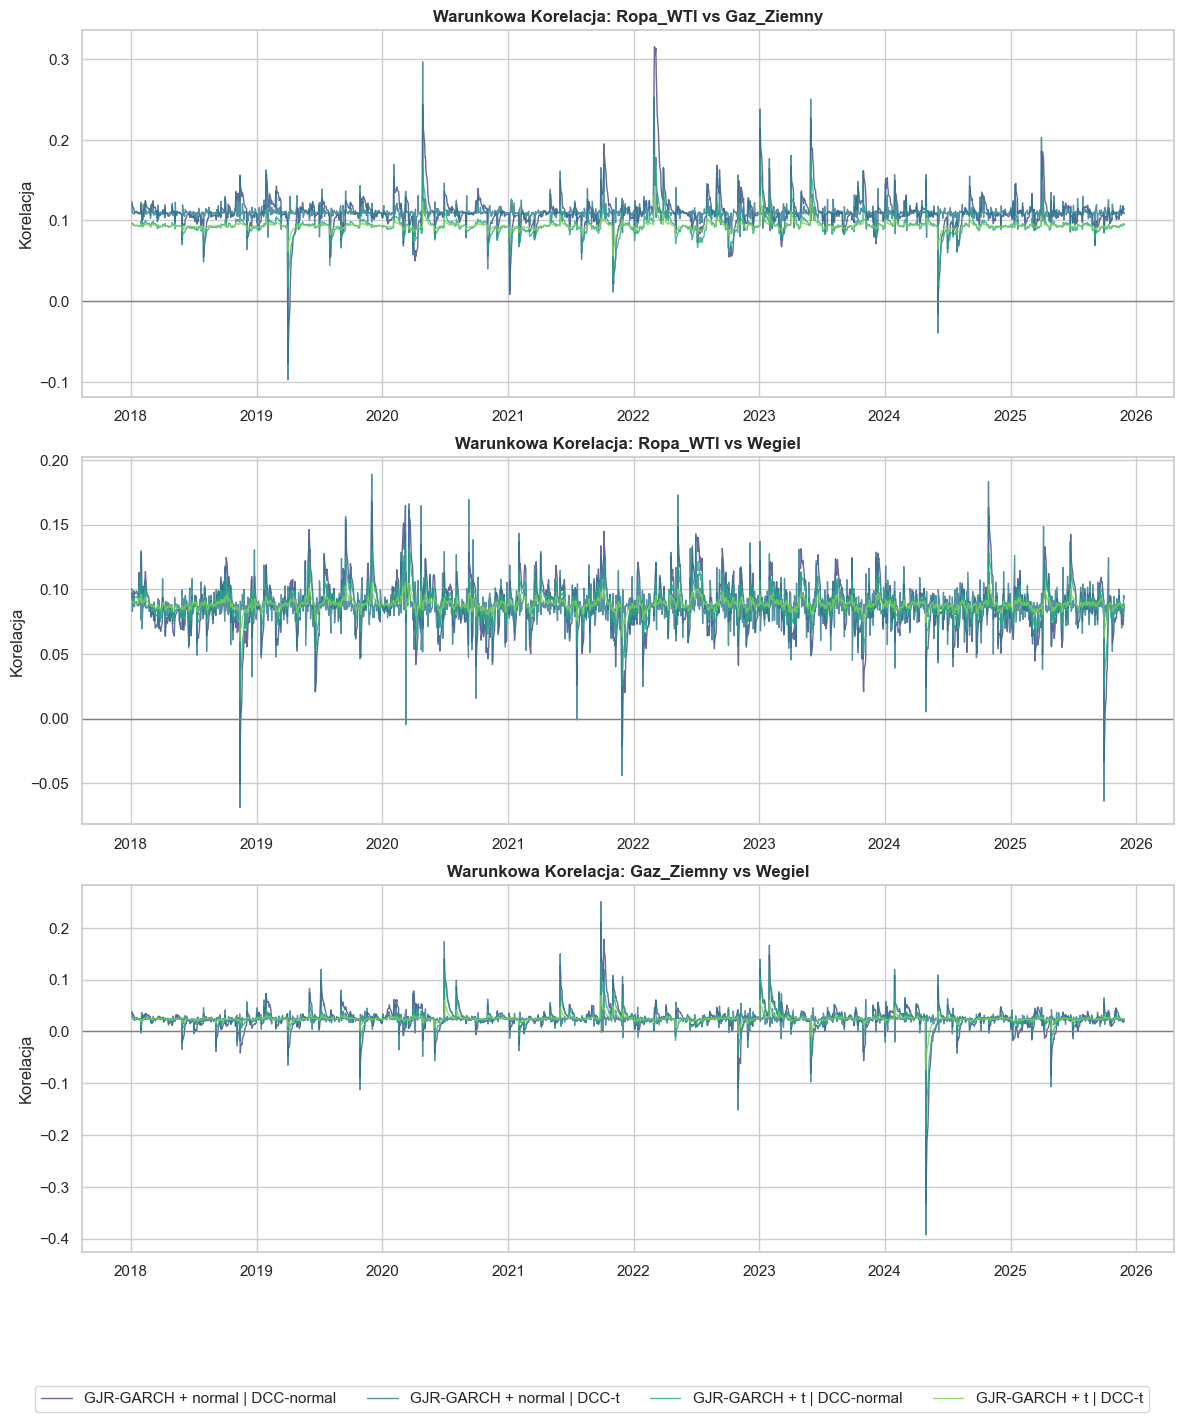

In [ ]:
def plot_dcc_comparisons(results, dates, asset_names, max_models_per_plot=4):
    """
    Wizualizacja warunkowych korelacji dla różnych scenariuszy DCC.
    Jeśli modeli jest dużo, dzieli wykresy na grupy.
    """
    import math

    pairs = [(0,1), (0,2), (1,2)]
    model_names = list(results.keys())
    n_models = len(model_names)

    # Podział na grupy
    n_groups = math.ceil(n_models / max_models_per_plot)

    for g in range(n_groups):
        fig, axes = plt.subplots(3, 1, figsize=(12, 14))
        start_idx = g * max_models_per_plot
        end_idx = min((g+1) * max_models_per_plot, n_models)
        current_models = model_names[start_idx:end_idx]

        # Paleta viridis dla aktualnej grupy modeli
        colors = sns.color_palette("viridis", n_colors=len(current_models))

        for idx, (i,j) in enumerate(pairs):
            ax = axes[idx]
            pair_name = f"{asset_names[i]} vs {asset_names[j]}"

            for model_idx, model_name in enumerate(current_models):
                corr_matrix = results[model_name]
                rho = corr_matrix[:, i, j]

                # Dopasowanie długości dat
                aligned_dates = dates[-len(rho):] if len(rho) < len(dates) else dates
                if len(rho) > len(dates):
                    rho = rho[-len(dates):]

                ax.plot(aligned_dates, rho,
                        label=model_name,
                        color=colors[model_idx],
                        linewidth=1,
                        alpha=0.8)

            ax.set_title(f'Warunkowa Korelacja: {pair_name}', fontweight='bold')
            ax.set_ylabel('Korelacja')
            ax.axhline(0, color='grey', linewidth=1)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        # Legenda dla aktualnej grupy
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=len(current_models), bbox_to_anchor=(0.5, -0.02))

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1)
        plt.show()


filtered_results = {k: v for k, v in results.items() if "SPECIAL" not in k}
plot_dcc_comparisons(filtered_results, log_returns.index, log_returns.columns, max_models_per_plot=4)


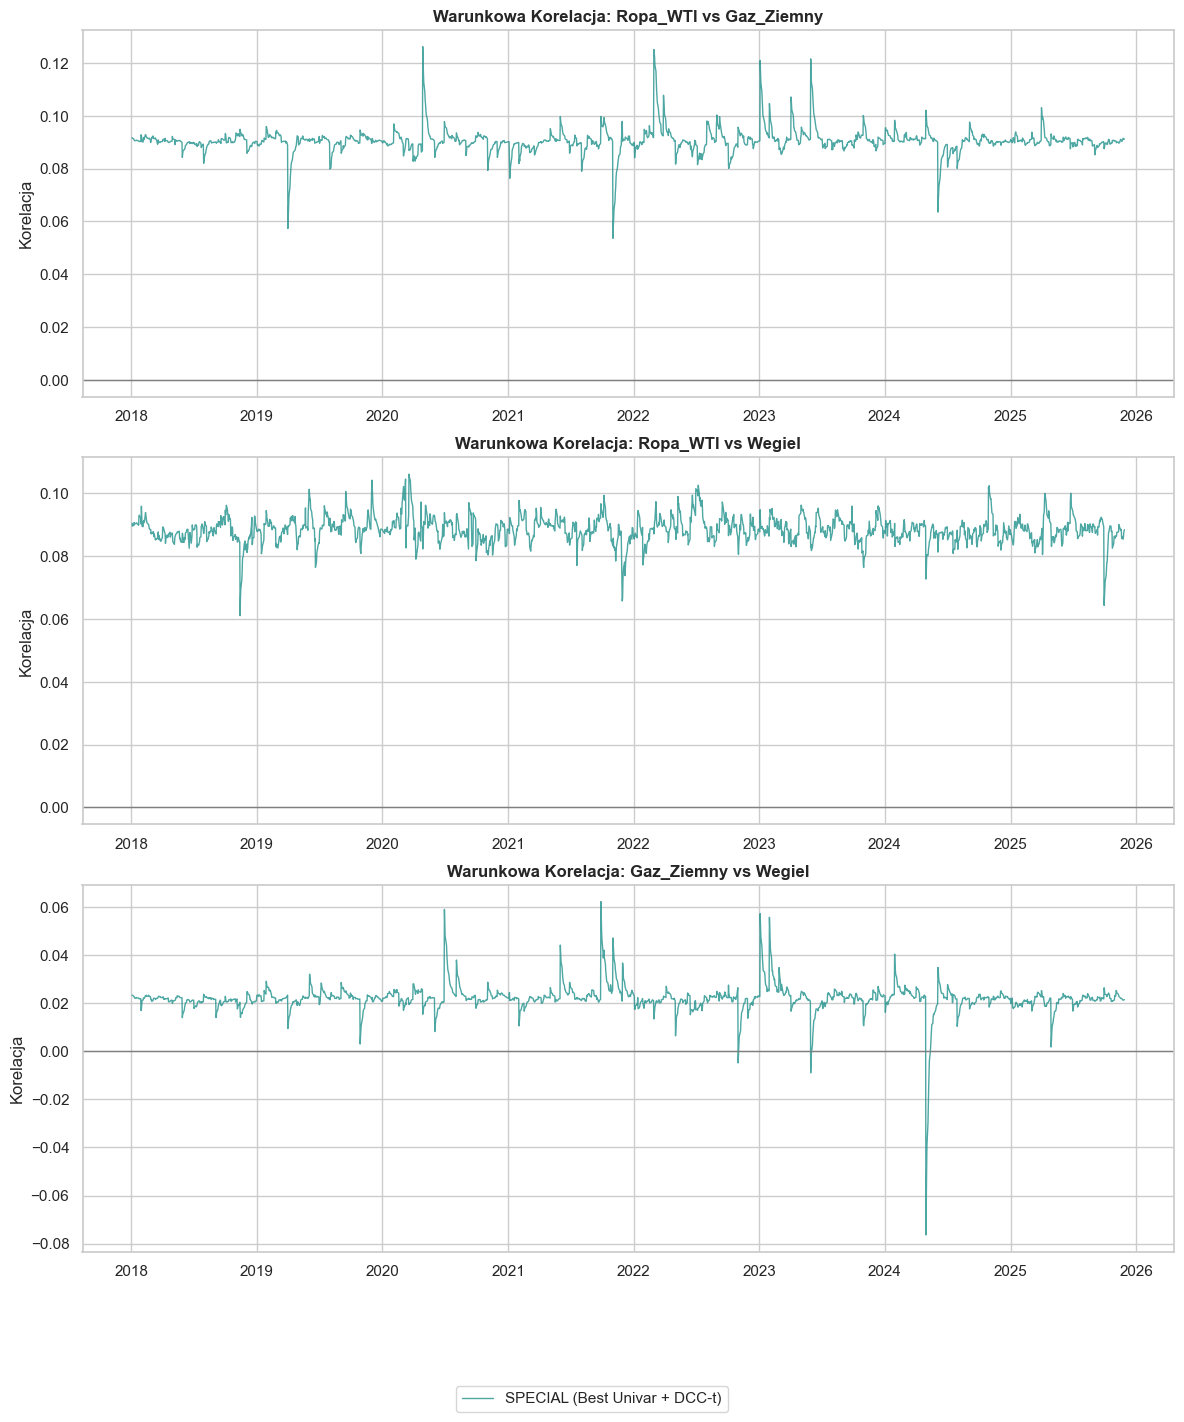

In [ ]:
filtered_results = {k: v for k, v in results.items() if "SPECIAL"  in k}
plot_dcc_comparisons(filtered_results, log_returns.index, log_returns.columns, max_models_per_plot=1)